# 5. Modeling

## 5.1 Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import os

## 5.2 Load previously processed data

In [2]:
# Intermediate data was saved as '../data/baf_cat_dummy_na_median_num_scaled.csv.gz' previously.
baf_data = pd.read_csv('../data/baf_cat_dummy_na_median_num_scaled.csv.gz', compression='gzip')


In [3]:
# Validate data types and non-null values.
baf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993563 entries, 0 to 993562
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        993563 non-null  int64  
 1   email_is_free                     993563 non-null  int64  
 2   phone_home_valid                  993563 non-null  int64  
 3   phone_mobile_valid                993563 non-null  int64  
 4   has_other_cards                   993563 non-null  int64  
 5   foreign_request                   993563 non-null  int64  
 6   keep_alive_session                993563 non-null  int64  
 7   payment_type_AA                   993563 non-null  int64  
 8   payment_type_AB                   993563 non-null  int64  
 9   payment_type_AC                   993563 non-null  int64  
 10  payment_type_AD                   993563 non-null  int64  
 11  payment_type_AE                   993563 non-null  i

## 5.3 Split data into training and testing subsets

All the features will be used for modeling at the first step.

In [4]:
# split dataset into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(baf_data.drop(columns='fraud_bool'), baf_data.fraud_bool, test_size=0.3, random_state=47)

In [5]:
X_train.shape, X_test.shape

((695494, 52), (298069, 52))

In [6]:
y_train.shape, y_test.shape

((695494,), (298069,))

## 5.4 Applying the Machine Learning models

Fraud or not is a classification problem. The following supervised learning classification models will be used:

- Logistic Regression
- K-Nearest Neighbor (KNN)
- Random Forest
- Support vector machine (SVM)
- Naive Bayes
- Gradient Boost

For evaluation metrics, F1 score, Recall, Precision, ROC AUC, PR AUC will be calculated and compared.

In [21]:
# Import
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve


### 5.4.1 Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

# First we will try LogisticRegresssion model without considering the class_weight

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight=None, random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294774     26]
 [  3231     38]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.59      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.79      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.989073         0.59375     0.011624  0.022802   

  roc_auc_score    pr_auc  
0      0.871519  0.130022  


F1 score 0.022 is very poor. Would it be related to inbalanced classes?

In [9]:
# Print target column `fraud_bool` value count
print(baf_data['fraud_bool'].value_counts())
# Print the pencentage of fraud instances of all records
fraud_bool_1 = len(baf_data[baf_data['fraud_bool']==1]) / len(baf_data)
fraud_bool_0 = len(baf_data[baf_data['fraud_bool']==0]) / len(baf_data)
print(f'fraud_bool=1 of all ratio: {fraud_bool_1: .3f}')
print(f'fraud_bool=0 of all ratio: {fraud_bool_0: .3f}')

fraud_bool
0    982568
1     10995
Name: count, dtype: int64
fraud_bool=1 of all ratio:  0.011
fraud_bool=0 of all ratio:  0.989


We can see that the fraud ratio is very low, only 1.1% of all in baf_data. Next we are going to try class_weight='balanced' in the modeling.

In [10]:
# Try the built in class_weight='balanced'

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight='balanced', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[237182  57618]
 [   716   2553]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.80    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.80      0.88    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.804294        0.042429     0.780973  0.080485   

  roc_auc_score    pr_auc  
0      0.872572  0.125288  


With the built in 'balanced' class_weight, Recall score increased to 0.78, but Precision decreased to 0.04 as false positive number also increased a lot. F1 score improved to 0.08, better still poor. Accuracy score and roc_auc score doesn't seem to be good choices for inbalanced data classification in the current model. F1 score and pr_auc may be more useful metrics.

In [23]:
# Hyperparameter GridSearch for better parameters.
# penalty, C, class_weight, and solver will be tried.

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'class_weight': [{0:0.001, 1:0.999}, {0:0.005, 1:0.995}, {0:0.01, 1:0.99}, 
                               {0:0.02, 1:0.98}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}], 
              'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
              }

logreg = LogisticRegression(penalty='l2', random_state=47, max_iter=100000)

cv = GridSearchCV(logreg, param_grid, scoring='f1', cv=5, n_jobs=-1)
cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000, random_state=47),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [{0: 0.001, 1: 0.999},
                                          {0: 0.005, 1: 0.995},
                                          {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98}, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='f1')

In [24]:
print(f'Best score: {cv.best_score_}')
print(f'Best parameters: {cv.best_params_}')

Best score: 0.21037044297173818
Best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}


In [26]:
cv.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 0.1, 1: 0.9}, max_iter=100000,
                   random_state=47)

We will use the best parameters found by GridSearchCV to apply logistic regression model for result.

In [16]:
# Use best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight={0: 0.1, 1: 0.9}, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[290285   4515]
 [  2399    870]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    294800
           1       0.16      0.27      0.20      3269

    accuracy                           0.98    298069
   macro avg       0.58      0.63      0.59    298069
weighted avg       0.98      0.98      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.976804         0.16156     0.266136  0.201063   

  roc_auc_score    pr_auc  
0       0.87217  0.128743  


While F1 score is 0.201, Recall and Precision are both low. Let's visulize the result the ROC curve and Precision Recall curve.

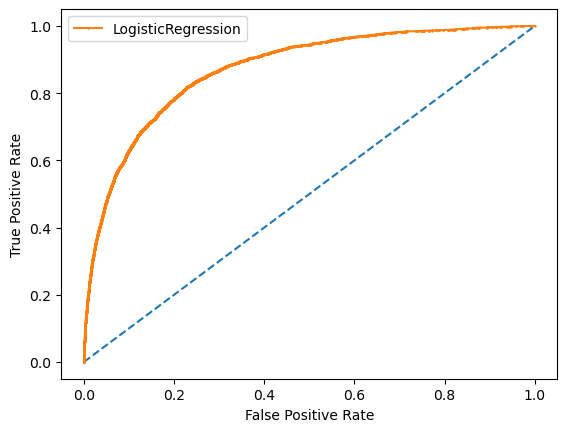

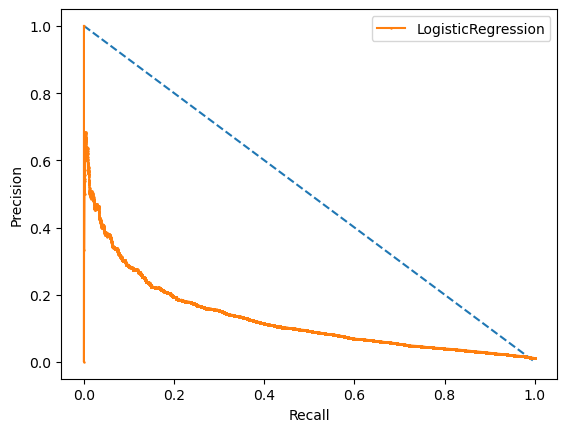

In [34]:
import matplotlib.pyplot as plt

fpr, tpr, thd = roc_curve(y_test, y_score)

# ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()